# Предсказания победителя в онлайн-игре
***

<img align="right" 
     src="https://upload.wikimedia.org/wikipedia/en/0/0b/Dota_2_%28Steam_2019%29.jpg" 
     alt="" width="250" height="350">

[Dota 2](https://en.wikipedia.org/wiki/Dota_2) — многопользовательская компьютерная игра жанра MOBA. Игроки играют между собой матчи. В каждом матче, как правило, участвует 10 человек. Матчи формируются из живой очереди, с учётом уровня игры всех игроков. Перед началом игры игроки автоматически разделяются на две команды по пять человек. Одна команда играет за светлую сторону (The Radiant), другая — за тёмную (The Dire). Цель каждой команды — уничтожить главное здание базы противника, трон.

**Цель пректа -** построить модель, которая по данным о первых пяти минутах матча будет предсказывать его исход — то есть определять команду-победителя.


**Исходные данные:**

|Название файла|Описание|
|:------|:--------|
|`final-statement.ipynb` и `final-statement.html`|постановка задачи, описание данных, инструкции по выполнению|
|`features.csv`|обучающая выборка|
|`features_test.csv` |тестовая выборка|


#### Описание признаков в таблице

- `match_id`: идентификатор матча в наборе данных
- `start_time`: время начала матча (unixtime)
- `lobby_type`: тип комнаты, в которой собираются игроки (расшифровка в `dictionaries/lobbies.csv`)
- Наборы признаков для каждого игрока (игроки команды Radiant — префикс `rN`, Dire — `dN`):
    - `r1_hero`: герой игрока (расшифровка в dictionaries/heroes.csv)
    - `r1_level`: максимальный достигнутый уровень героя (за первые 5 игровых минут)
    - `r1_xp`: максимальный полученный опыт
    - `r1_gold`: достигнутая ценность героя
    - `r1_lh`: число убитых юнитов
    - `r1_kills`: число убитых игроков
    - `r1_deaths`: число смертей героя
    - `r1_items`: число купленных предметов
- Признаки события "первая кровь" (first blood). Если событие "первая кровь" не успело произойти за первые 5 минут, то признаки принимают пропущенное значение
    - `first_blood_time`: игровое время первой крови
    - `first_blood_team`: команда, совершившая первую кровь (0 — Radiant, 1 — Dire)
    - `first_blood_player1`: игрок, причастный к событию
    - `first_blood_player2`: второй игрок, причастный к событию
- Признаки для каждой команды (префиксы `radiant_` и `dire_`)
    - `radiant_bottle_time`: время первого приобретения командой предмета "bottle"
    - `radiant_courier_time`: время приобретения предмета "courier" 
    - `radiant_flying_courier_time`: время приобретения предмета "flying_courier" 
    - `radiant_tpscroll_count`: число предметов "tpscroll" за первые 5 минут
    - `radiant_boots_count`: число предметов "boots"
    - `radiant_ward_observer_count`: число предметов "ward_observer"
    - `radiant_ward_sentry_count`: число предметов "ward_sentry"
    - `radiant_first_ward_time`: время установки командой первого "наблюдателя", т.е. предмета, который позволяет видеть часть игрового поля
- Итог матча (данные поля отсутствуют в тестовой выборке, поскольку содержат информацию, выходящую за пределы первых 5 минут матча)
    - `duration`: длительность
    - `radiant_win`: 1, если победила команда Radiant, 0 — иначе
    - Состояние башен и барраков к концу матча (см. описание полей набора данных)
        - `tower_status_radiant`
        - `tower_status_dire`
        - `barracks_status_radiant`
        - `barracks_status_dire`

-----
## Содержание:
1. [Подход 1: градиентный бустинг "в лоб"](#v_lob)<br/>
    1.1. [Предобработка данных и формирование общей таблицы.](#load_data)<br/>
    1.2. [Проверка выборки на наличие пропусков с помощью функции count().](#count_na)<br/>
    1.3. [Замена пропусков на нули с помощью функции fillna().](#fill_na)<br/>
    1.4. [Какой столбец содержит целевую переменную? ](#target)<br/>
    1.5. [Обучение модели GradientBoostingClassifier](#model_1)<br/>
    1.6. [Отчет](#report_1)<br/>
2. [Подход 2: логистическая регрессия](#lr)<br/>
    2.1. [Оценка качества логистической регрессии.](#lr_1)<br/>
    2.2. [Категориальные признаки](#lr_2)<br/>
    2.3. [Количество уникальных героев](#lr_3)<br/>
    2.4. ["мешок слов" для кодирования информации](#lr_4)<br/>
    2.5. [Кросс-валидация для логистической регрессии на новой выборке](#lr_5)<br/>
    2.6. [Тестирование модели](#lr_6)<br/>
    2.7. [Отчет](#report_2)<br/>
    
---

In [1]:
# импорт библиотек
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

## 1. Подход 1: градиентный бустинг "в лоб"  <a name="v_lob"></a>

### 1.1 Загрузка данных.  <a name="load_data"></a>

Данные с признаками загрузим из файла features.csv.

Удалим признаки, связанные с итогами матча (они помечены в описании данных как отсутствующие в тестовой выборке).

In [2]:
# загрузка данных
train = pd.read_csv("data/features.csv", index_col="match_id")
train.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,4,2,2,-52.0,2874,1,1796,0,51,0
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,4,3,1,-5.0,2463,1,1974,0,63,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,4,3,1,13.0,2130,0,0,1830,0,63
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,4,2,0,27.0,1459,0,1920,2047,50,63
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,3,3,0,-16.0,2449,0,4,1974,3,63


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97230 entries, 0 to 114406
Columns: 108 entries, start_time to barracks_status_dire
dtypes: float64(12), int64(96)
memory usage: 80.9 MB


In [4]:
# удаление признаков с итогами матча
train.drop([
    "duration",
    "tower_status_radiant",
    "tower_status_dire",
    "barracks_status_radiant",
    "barracks_status_dire",
], axis=1, inplace=True)

### 1.2. Проверка выборки на наличие пропусков с помощью функции count(). <a name="count_na"></a>

In [5]:
# проверка на наличие пропусков
count_na = len(train) - train.count()
count_na[count_na > 0].sort_values(ascending=False) / len(train)

first_blood_player2            0.452402
radiant_flying_courier_time    0.282619
dire_flying_courier_time       0.268415
first_blood_time               0.201100
first_blood_team               0.201100
first_blood_player1            0.201100
dire_bottle_time               0.166029
radiant_bottle_time            0.161380
radiant_first_ward_time        0.018883
dire_first_ward_time           0.018780
radiant_courier_time           0.007117
dire_courier_time              0.006953
dtype: float64

### Обоснование пропусков:
* **first_blood_player2** (второй игрок, причастный к событию) - первое убийство может быть совершено одним игроком, это достаточно частое явление и происходит в 45% случаев.
* **radiant_flying_courier_time** (время приобретения предмета "flying_courier") - в 28% случаев команда не покупает "flying_courier" в первые 5 минут игры.
* **dire_flying_courier_time** - аналогично **radiant_flying_courier_time**, процент почти тот же (26%).
* **first_blood_time** (игровое время первой крови) - в 20% случаев первой крови нет в первые 5 минут игры.
* **first_blood_team** (команда, совершившая первую кровь) - аналогично **first_blood_time**, процент совпадает (20%).
* **first_blood_player1** (игрок, причастный к событию) - аналогично **first_blood_time**, процент совпадает (20%).
* **dire_bottle_time** (время первого приобретения командой предмета "bottle") - в 16% случаев команда не приобретает предмет "bottle" в первые 5 минут игры.
* **radiant_bottle_time** - аналогично **dire_bottle_time**, процент почти тот же (16%).
* **radiant_first_ward_time** (время установки командой первого "наблюдателя") - очень редкое явление, в 1% случаев команда не ставит "наблюдателя" в первые 5 минут игры.
* **dire_first_ward_time** - аналогично **radiant_first_ward_time**, процент почти тот же (1%).
* **radiant_courier_time** (время приобретения предмета "courier") - самое редкое явление, в 0.5% случаев команда не приобретает предмет "courier" в первые 5 минут игры.
* **dire_courier_time** - аналогично **radiant_courier_time**, процент почти тот же (0.5%).

### 1.3. Замена пропусков на нули с помощью функции fillna(). <a name="fill_na"></a>

На самом деле этот способ является предпочтительным для логистической регрессии, поскольку он позволит пропущенному значению не вносить никакого вклада в предсказание. Для деревьев часто лучшим вариантом оказывается замена пропуска на очень большое или очень маленькое значение — в этом случае при построении разбиения вершины можно будет отправить объекты с пропусками в отдельную ветвь дерева. Также есть и другие подходы — например, замена пропуска на среднее значение признака. Мы не требуем этого в задании, но при желании попробуйте разные подходы к обработке пропусков и сравните их между собой.

In [6]:
# замена пропусков
train.fillna(0, inplace=True)

In [7]:
# проверка на наличие пропусков
count_na = len(train) - train.count()
count_na[count_na > 0].sort_values(ascending=False) / len(train)

Series([], dtype: float64)

### 1.4. Какой столбец содержит целевую переменную?  <a name="target"></a>

Целевая переменная записана в столбце `radiant_win` и принимает значения 1, если победила команда Radiant, 0 — иначе

In [8]:
# разделение данных на признаки и целевую
features_train = train.drop("radiant_win", axis=1)
target_train = train["radiant_win"]

### 1.5. Забудем, что в выборке есть категориальные признаки, и попробуем обучить градиентный бустинг над деревьями на имеющейся матрице "объекты-признаки".  <a name="model_1"></a>

Зафиксируйте генератор разбиений для кросс-валидации по 5 блокам (KFold), не забудьте перемешать при этом выборку (shuffle=True), поскольку данные в таблице отсортированы по времени, и без перемешивания можно столкнуться с нежелательными эффектами при оценивании качества. Оцените качество градиентного бустинга (GradientBoostingClassifier) с помощью данной кросс-валидации, попробуйте при этом разное количество деревьев (как минимум протестируйте следующие значения для количества деревьев: 10, 20, 30).
- Долго ли настраивались классификаторы?
- Достигнут ли оптимум на испытанных значениях параметра n_estimators, или же качество, скорее всего, продолжит расти при дальнейшем его увеличении?

In [9]:
# разбиение на подвыборки для кросс-валидации
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [10]:
# функция с моделью GradientBoostingClassifier
def score_gb(X, y):
    scores = {}

    for estim in [10, 20, 30, 50, 100, 250]:
        model = GradientBoostingClassifier(n_estimators=estim, random_state=42)

        start_time = datetime.datetime.now()
        score = cross_val_score(model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1).mean()
        scores[estim] = score
        
        print(f"n_estimators {estim}")
        print(f"Score: {score:.6f}")
        print(f"Time elapsed: {datetime.datetime.now() - start_time}")     
        print()
        
    return pd.Series(scores)

In [11]:
# запуск функции
scores = score_gb(features_train, target_train)

n_estimators 10
Score: 0.664851
Time elapsed: 0:00:55.210335

n_estimators 20
Score: 0.682462
Time elapsed: 0:01:09.120882

n_estimators 30
Score: 0.690006
Time elapsed: 0:01:42.890202

n_estimators 50
Score: 0.697494
Time elapsed: 0:03:13.070427

n_estimators 100
Score: 0.706223
Time elapsed: 0:05:31.003054

n_estimators 250
Score: 0.715915
Time elapsed: 0:17:50.529434



Text(0.5, 1.0, 'Скоринг модели в зависимости от количества n_estimators')

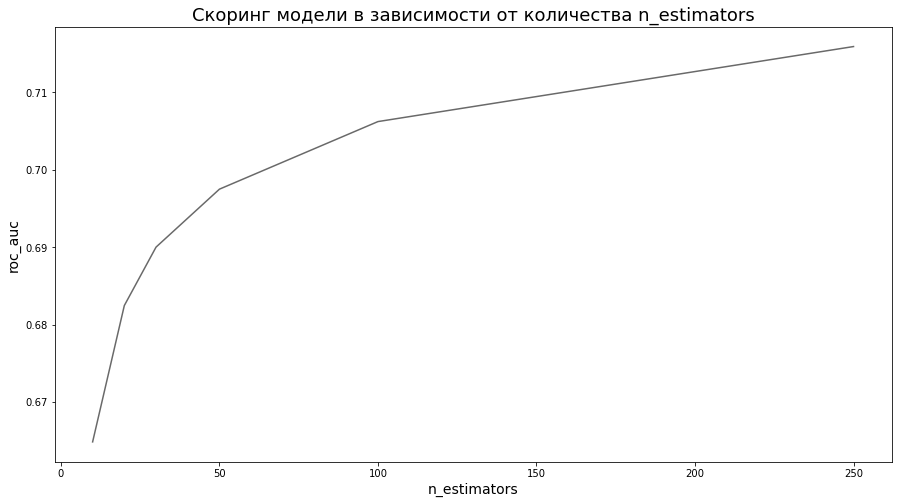

In [12]:
# визуализация скоринга 
plt.figure(figsize=(15,8))
scores.plot(color='dimgray')
plt.xlabel('n_estimators', size=14)
plt.ylabel('roc_auc', size=14)
plt.title('Скоринг модели в зависимости от количества n_estimators', size=18)

### Отчет <a name="report_1"></a>

1. **Какие признаки имеют пропуски среди своих значений? Что могут означать пропуски в этих признаках (ответьте на этот вопрос для двух любых признаков)?**<br/>
    - **first_blood_player2** (второй игрок, причастный к событию) - первое убийство может быть совершено одним игроком, это достаточно частое явление и происходит в 45% случаев.
    - **radiant_flying_courier_time** (время приобретения предмета "flying_courier") - в 28% случаев команда не покупает "flying_courier" в первые 5 минут игры.<br/><br/>
2. **Как называется столбец, содержащий целевую переменную?**<br/><br/>
    Целевая переменная записана в столбце `radiant_win` и принимает значения 1, если победила команда Radiant, 0 — иначе<br/><br/>
3. **Как долго проводилась кросс-валидация для градиентного бустинга с 30 деревьями? Какое качество при этом получилось? Напомним, что в данном задании мы используем метрику качества AUC-ROC.**<br/><br/>
    Кросс-валидация заняла 0:02:01. Score: 0.690.<br/><br/>
4. **Имеет ли смысл использовать больше 30 деревьев в градиентном бустинге? Что бы вы предложили делать, чтобы ускорить его обучение при увеличении количества деревьев?**<br/><br/>
    Использовать более 30 деревьев имеет смысл, т.к. с ростом количества деревьев улучшается качество метрики.<br/>
    Чтобы повысить скорость обучения можно попробовать:
        - Использовать для обучения и кросс-валидации не всю выборку, а некоторое ее подмножество — например, половину объектов. Подмножество лучше всего брать случайным, а не формировать его из первых m объектов.
        - Упростить модель — например, уменьшить глубину деревьев в градиентом бустинге (max_depth).
------

## 2. Подход 2: логистическая регрессия  <a name="lr"></a>

### 2.1 Оценка качества логистической регрессии <a name="lr_1"></a>

(sklearn.linear_model.LogisticRegression с L2-регуляризацией) с помощью кросс-валидации по той же схеме, которая использовалась для градиентного бустинга. 

Подберите при этом лучший параметр регуляризации (C). Какое наилучшее качество у вас получилось? Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?

In [13]:
# стандартизация данных
scaler = StandardScaler()
features_train_scaler = pd.DataFrame(scaler.fit_transform(features_train), 
                                     index=features_train.index, 
                                     columns=features_train.columns)

display(features_train_scaler.head(2))

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time
match_id,,,,,,,,,,,,,,,,,,,,,
0,-2.544364,1.540688,-1.244228,1.400808,1.525972,0.734957,0.969743,-0.537757,-0.578083,-0.509023,...,-0.987486,1.066448,-0.041743,-0.262922,0.640648,0.018054,0.562864,-0.551154,1.846004,-1.121494
1,-2.540452,-0.927798,-0.292258,0.501314,-0.080139,-0.247570,-0.246859,-0.537757,1.017574,1.492930,...,-0.987486,-0.338591,0.578946,-0.262922,0.379585,1.066668,0.562864,0.678170,0.437788,0.043947


In [14]:
# функция с моделью LogisticRegression
def score_lr(X, y):
    score_lr = {}

    for c in [0.0001, 0.001, 0.01, 0.1, 1]:
        
        model = LogisticRegression(C=c, random_state=42)

        start_time = datetime.datetime.now()
        
        score = cross_val_score(model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1).mean()
        score_lr[c] = score
        
        print(f"C={c}")
        print(f"Score: {score:.6f}")
        print(f"Time elapsed: {datetime.datetime.now() - start_time}")
        print()

    return pd.Series(score_lr)

In [15]:
# запуск функции
scores_lr = score_lr(features_train_scaler, target_train)

C=0.0001
Score: 0.711352
Time elapsed: 0:00:05.615266

C=0.001
Score: 0.716363
Time elapsed: 0:00:20.238129

C=0.01
Score: 0.716550
Time elapsed: 0:00:05.609459

C=0.1
Score: 0.716527
Time elapsed: 0:00:06.374018

C=1
Score: 0.716522
Time elapsed: 0:00:05.291878



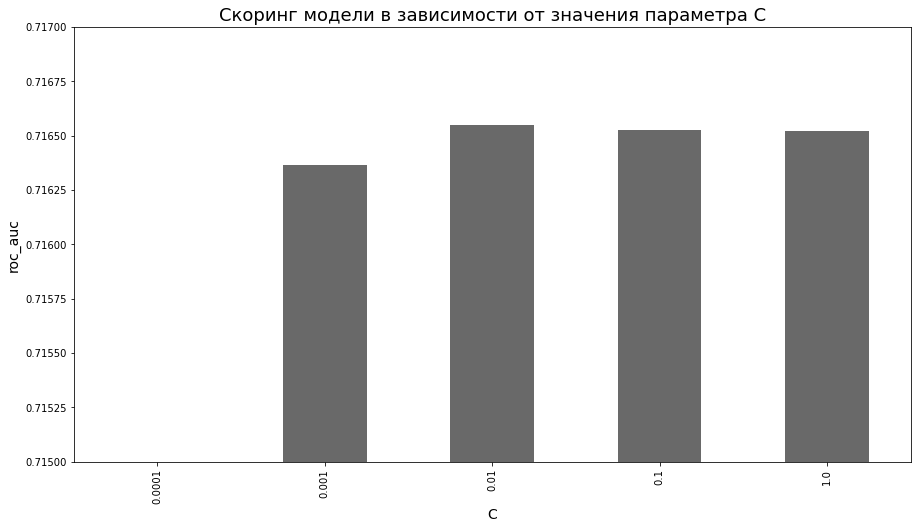

In [16]:
# визуализация скоринга 
fig, ax = plt.subplots(figsize=(15,8))

scores_lr.plot(kind = 'bar', color='dimgray')
plt.xlabel('C', size=14)
plt.ylabel('roc_auc', size=14)
plt.title('Скоринг модели в зависимости от значения параметра C', size=18)
ax.set_ylim(0.715, 0.717)
plt.show()

In [17]:
# функция для печати лучшего результата
def print_best_lr_score(scores):
    best_iteration = scores.sort_values(ascending=False).head(1)
    best_C = best_iteration.index[0]
    best_score = best_iteration.values[0]

    print(f"Наилучшее значение показателя AUC-ROC достигается при C = {best_C:.2f} и равно {best_score:.6f}.")

In [18]:
# запуск функции
print_best_lr_score(scores_lr)

Наилучшее значение показателя AUC-ROC достигается при C = 0.01 и равно 0.716550.


Это сравнимо с градиентным бустингом по 250 деревьям, при этом логистическая регрессия работает заметно быстрее. Отсутствие разницы с градиентным бустингом может говорить о том, что характер связи между признакми и целевой переменной - линейный. Тогда такая связь хорошо описывается логистической регрессией и более сложные модели не нужны.

### 2.2. Среди признаков в выборке есть категориальные, которые мы использовали как числовые, что вряд ли является хорошей идеей. <a name="lr_2"></a>

Категориальных признаков в этой задаче одиннадцать: lobby_type и r1_hero, r2_hero, ..., r5_hero, d1_hero, d2_hero, ..., d5_hero. 

Уберите их из выборки, и проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. Изменилось ли качество? Чем вы можете это объяснить?

In [19]:
hero_columns = [f"r{i}_hero" for i in range (1, 6)] + [f"d{i}_hero" for i in range (1, 6)]
cat_columns = ["lobby_type"] + hero_columns
features_train_scaler.drop(cat_columns, axis=1, inplace=True)

In [20]:
scores_lr_2 = score_lr(features_train_scaler, target_train)

C=0.0001
Score: 0.711333
Time elapsed: 0:00:01.734447

C=0.001
Score: 0.716376
Time elapsed: 0:00:04.409378

C=0.01
Score: 0.716559
Time elapsed: 0:00:07.647162

C=0.1
Score: 0.716534
Time elapsed: 0:00:06.230943

C=1
Score: 0.716530
Time elapsed: 0:00:06.996340



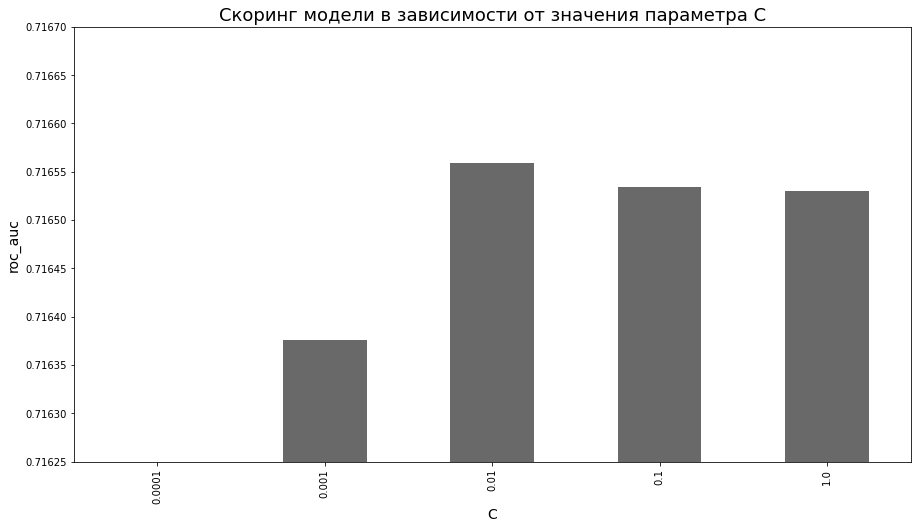

In [21]:
# визуализация скоринга 
fig, ax = plt.subplots(figsize=(15,8))

scores_lr_2.plot(kind = 'bar', color='dimgray')
plt.xlabel('C', size=14)
plt.ylabel('roc_auc', size=14)
plt.title('Скоринг модели в зависимости от значения параметра C', size=18)
ax.set_ylim(0.71625, 0.7167)
plt.show()

In [22]:
print_best_lr_score(scores_lr_2)

Наилучшее значение показателя AUC-ROC достигается при C = 0.01 и равно 0.716559.


Удаление категориальных признаков не повлияло на качество предсказания. Получается, что в предыдущей модели эти признаки никак не влияли на результат предсказания, модель смогла распознать этот шум.

### 2.3. На предыдущем шаге мы исключили из выборки признаки rM_hero и dM_hero, которые показывают, какие именно герои играли за каждую команду. <a name="lr_3"></a>

Это важные признаки — герои имеют разные характеристики, и некоторые из них выигрывают чаще, чем другие. Выясните из данных, сколько различных идентификаторов героев существует в данной игре (вам может пригодиться фукнция unique или value_counts).

In [23]:
# проверна уникальных героев
unique_heroes = np.unique(train[hero_columns])
print(f"Уникальных героев: {len(unique_heroes)}")   
display(unique_heroes)

Уникальных героев: 108


array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 109, 110, 112])

### 2.4. "мешок слов" для кодирования информации о героях <a name="lr_4"></a>

Воспользуемся подходом "мешок слов" для кодирования информации о героях. Пусть всего в игре имеет N различных героев. Сформируем N признаков, при этом i-й будет равен нулю, если i-й герой не участвовал в матче; единице, если i-й герой играл за команду Radiant; минус единице, если i-й герой играл за команду Dire. Ниже вы можете найти код, который выполняет данной преобразование. Добавьте полученные признаки к числовым, которые вы использовали во втором пункте данного этапа.

In [24]:
# N — количество различных героев в выборке
def bag_words(data: pd.DataFrame) -> pd.DataFrame:
    X_pick = np.zeros((data.shape[0], 112))

    for i, match_id in enumerate(data.index):
        for p in range(1, 6):
            X_pick[i, data.loc[match_id, f"r{p}_hero"] - 1] = 1
            X_pick[i, data.loc[match_id, f"d{p}_hero"] - 1] = -1

    return pd.DataFrame(X_pick, index=data.index, columns=[f"hero_{i}" for i in range(112)])

X_pick = bag_words(train)
X_pick.head(2)

,hero_0,hero_1,hero_2,hero_3,hero_4,hero_5,hero_6,hero_7,hero_8,hero_9,...,hero_102,hero_103,hero_104,hero_105,hero_106,hero_107,hero_108,hero_109,hero_110,hero_111
match_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
# склеивание даных
features_train_pick = pd.concat([features_train_scaler, X_pick], axis=1)

### 2.5. Кросс-валидация для логистической регрессии на новой выборке.  <a name="lr_5"></a>

Проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. Какое получилось качество? Улучшилось ли оно? Чем вы можете это объяснить?

In [26]:
# запуск фунции с можеделью
scores_lr_3 = score_lr(features_train_pick, target_train)

C=0.0001
Score: 0.725038
Time elapsed: 0:00:30.699197

C=0.001
Score: 0.746333
Time elapsed: 0:00:07.832178

C=0.01
Score: 0.751739
Time elapsed: 0:00:13.370138

C=0.1
Score: 0.751946
Time elapsed: 0:00:18.689357

C=1
Score: 0.751927
Time elapsed: 0:00:17.982460



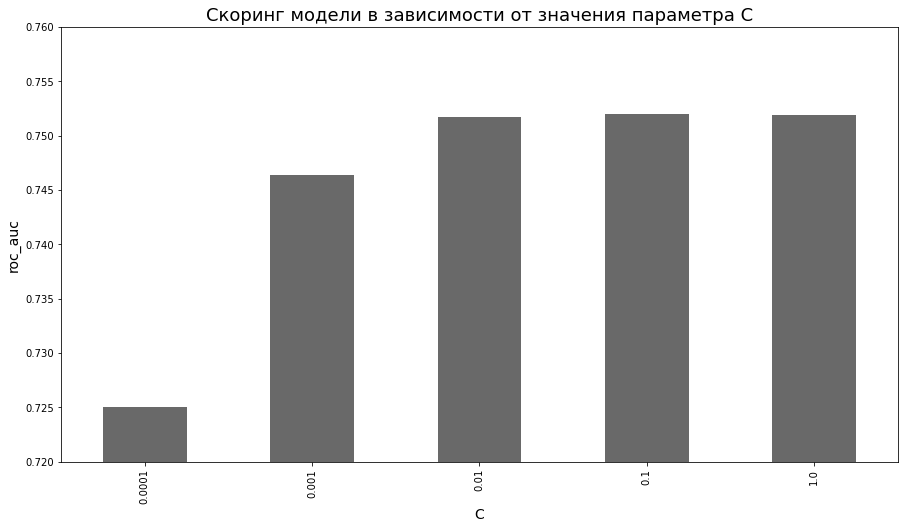

In [27]:
# визуализация скоринга 
fig, ax = plt.subplots(figsize=(15,8))

scores_lr_3.plot(kind = 'bar', color='dimgray')
plt.xlabel('C', size=14)
plt.ylabel('roc_auc', size=14)
plt.title('Скоринг модели в зависимости от значения параметра C', size=18)
ax.set_ylim(0.72, 0.76)
plt.show()

In [28]:
# печать лучшего результата
print_best_lr_score(scores_lr_3)

Наилучшее значение показателя AUC-ROC достигается при C = 0.10 и равно 0.751946.


После добавления "мешка слов" по героям качество заметно улучшилось. 

### 2.6. Тестирование модели. <a name="lr_6"></a>

Постройте предсказания вероятностей победы команды Radiant для тестовой выборки с помощью лучшей из изученных моделей (лучшей с точки зрения AUC-ROC на кросс-валидации). Убедитесь, что предсказанные вероятности адекватные — находятся на отрезке [0, 1], не совпадают между собой (т.е. что модель не получилась константной).


In [29]:
# загрузста тестовых данных 
test = pd.read_csv("data/features_test.csv", index_col="match_id")
test.fillna(0, inplace=True)
test.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time
match_id,,,,,,,,,,,,,,,,,,,,,
6,1430287923,0,93,4,1103,1089,8,0,1,9,...,0,12.0,247.0,-86.0,272.0,3,4,2,0,118.0
7,1430293357,1,20,2,556,570,1,0,0,9,...,2,-29.0,168.0,-54.0,0.0,3,2,2,1,16.0
10,1430301774,1,112,2,751,808,1,0,0,13,...,1,-22.0,46.0,-87.0,186.0,1,3,3,0,-34.0
13,1430323933,1,27,3,708,903,1,1,1,11,...,2,-49.0,30.0,-89.0,210.0,3,4,2,1,-26.0
16,1430331112,1,39,4,1259,661,4,0,0,9,...,0,36.0,180.0,-86.0,180.0,1,3,2,1,-33.0


In [30]:
# обучение модели
model = (LogisticRegression(C=0.1,
                            random_state=42
                           )
         .fit(features_train_pick, target_train)
        )

/home/evgeniy/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [31]:
# подготовка тестовых данных
features_test = pd.DataFrame(scaler.transform(test), index=test.index, columns=test.columns)
features_test.drop(cat_columns, axis=1, inplace=True)
features_test = pd.concat([features_test, bag_words(test)], axis=1)
features_test

,start_time,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,r2_level,r2_xp,...,hero_102,hero_103,hero_104,hero_105,hero_106,hero_107,hero_108,hero_109,hero_110,hero_111
match_id,,,,,,,,,,,,,,,,,,,,,
6,-2.528200,0.501314,-0.230161,-0.126909,-0.357459,-0.537757,1.017574,0.291758,-0.332256,-0.011207,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,-2.527214,-1.297676,-1.195592,-1.245180,-1.131661,-0.537757,-0.578083,0.291758,0.578881,0.008600,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,-2.525688,-1.297676,-0.851426,-0.732370,-1.131661,-0.537757,-0.578083,1.893320,-1.243393,-1.383288,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
13,-2.521671,-0.398181,-0.927319,-0.527677,-1.131661,0.968527,1.017574,1.092539,-1.243393,-0.931329,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0
16,-2.520369,0.501314,0.045173,-1.049106,-0.799860,-0.537757,-0.578083,0.291758,1.490017,0.925122,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114369,1.084410,1.400808,1.448314,1.708865,1.743945,-0.537757,1.017574,-0.108632,0.578881,0.487568,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
114377,1.086240,-0.398181,-0.856720,-1.169767,-1.131661,-0.537757,-0.578083,1.492930,-0.332256,-0.106640,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
114378,1.086370,-1.297676,-1.162058,-1.398161,-1.242261,-0.537757,-0.578083,-0.108632,-0.332256,-0.886314,...,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
# использвоание модели
preds = (model.predict_proba(features_test)[:, 1])
preds_df = pd.Series(preds)
preds_df

0        0.823876
1        0.753068
2        0.187789
3        0.861986
4        0.240169
           ...   
17172    0.719129
17173    0.631509
17174    0.234603
17175    0.625038
17176    0.426141
Length: 17177, dtype: float64

<AxesSubplot:>

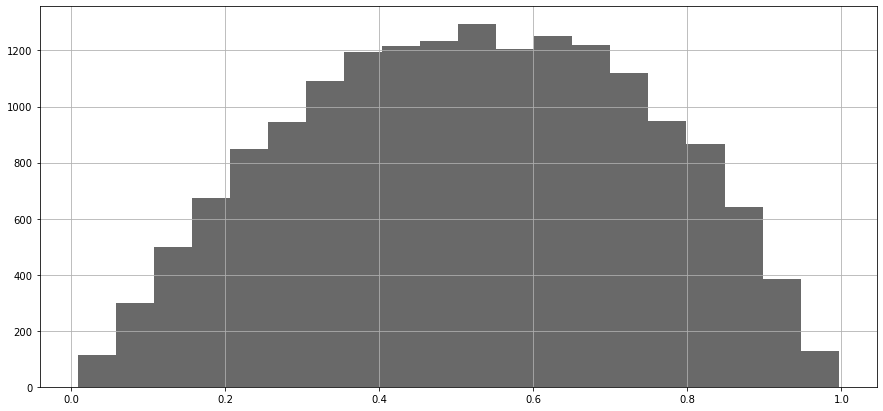

In [33]:
# визуализация скоринга 
fig, ax = plt.subplots(figsize=(15,7))

preds_df.hist(bins=20, color='dimgray')

In [34]:
submission = pd.DataFrame(data=preds, index=test.index, columns=['radiant_win'])
submission.head()

,radiant_win
match_id,
6,0.823876
7,0.753068
10,0.187789
13,0.861986
16,0.240169


In [35]:
submission = pd.DataFrame({'match_id': test.index,
                           'radiant_win': preds
                          }
                         )
submission

,match_id,radiant_win
0,6,0.823876
1,7,0.753068
2,10,0.187789
3,13,0.861986
4,16,0.240169
...,...,...
17172,114369,0.719129
17173,114377,0.631509
17174,114378,0.234603
17175,114393,0.625038


In [36]:

print(submission.shape)

filename = 'Predictions'
submission.to_csv(filename, index=False)
print('Saved file: ' + filename)

(17177, 2)
Saved file: Predictions


In [37]:
submission['radiant_win'].describe()

count    17177.000000
mean         0.517031
std          0.220963
min          0.008432
25%          0.346091
50%          0.522135
75%          0.691758
max          0.996372
Name: radiant_win, dtype: float64

In [38]:
print(f"Min proba: {submission['radiant_win'].min()}\n Max proba: {submission['radiant_win'].max()}")

Min proba: 0.00843219698923492
 Max proba: 0.9963720528697849


/home/evgeniy/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/evgeniy/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

### Отчет <a name="report_2"></a>

1. **Какое качество получилось у логистической регрессии над всеми исходными признаками? Как оно соотносится с качеством градиентного бустинга? Чем можно объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?**<br/>
    - Наилучшее значение показателя AUC-ROC равно 0.7165. Это сравнимо с градиентным бустингом по 250 деревьям, при этом логистическая регрессия работает заметно быстрее. Отсутствие разницы с градиентным бустингом может говорить о том, что характер связи между данными фичами и целевой переменной - линейный. Тогда такая связь хорошо описывается логистической регрессией и более сложные модели не нужны.<br/><br/>
2. **Как влияет на качество логистической регрессии удаление категориальных признаков (укажите новое значение метрики качества)? Чем можно объяснить это изменение?**<br/>
    - Наилучшее значение показателя AUC-ROC равно 0.7166. Удаление категориальных признаков не повлияло на качество предсказания. Получается, что в предыдущей модели эти признаки никак не влияли на результат предсказания, модель смогла распознать этот шум.<br/><br/>
3. **Сколько различных идентификаторов героев существует в данной игре?**<br/>
    - Уникальных героев: 108<br/><br/>
4. **Какое получилось качество при добавлении "мешка слов" по героям? Улучшилось ли оно по сравнению с предыдущим вариантом? Чем можно это объяснить?**<br/>
    - Наилучшее значение показателя AUC-ROC равно 0.7519. После добавления "мешка слов", качество заметно улучшилось.<br/><br/>
5. **Какое минимальное и максимальное значение прогноза на тестовой выборке получилось у лучшего из алгоритмов?**<br/>
    - Min proba: 0.008
    - Max proba: 0.996<br/><br/>
------